# **Homework 10:** Language models

In [ ]:
# Uncomment for Colab
# !yes | pip uninstall torch
# !yes | pip uninstall torchtext
# !yes | pip install torch==2.3.0
# !yes | pip install torchtext==0.18

# Run me to get the data (should be included!)
#!wget https://gist.githubusercontent.com/gabehope/286a065f3b7cc081af5f3e8d71502e63/raw/d31a233d8ade78ac5cbd8ecfa45f184017812c52/dataset.txt

# Part 0: Setup

There are no questions in this section, the following code simply sets up a text dataset to learn from. This cell make take some time to run.

**If you have issues running this cell on your own computer it may be an issue with the torch & torchtext versions, see [here](https://stackoverflow.com/questions/78933082/attributeerror-when-importing-torchtext-symbol-not-found-in-libc10-dylib)**.

In [1]:
import torch
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import torch.nn as nn
import torchtext.transforms as transforms
import tqdm
from torchtext.data import get_tokenizer
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, filename='dataset.txt', translation=True):
        self.translation = translation # Flag for translation or generation dataset

        # Read the original dataset and split it into the English and Italian sentences
        self.data = pd.read_csv(filename, sep='\t', header=None)
        self.data[[0]].to_csv('eng_data.csv', index=False, header=False)
        self.data[[1]].to_csv('ita_data.csv', index=False, header=False)

        # Use the sentence-piece tokenizer to create a set of 1000 tokens for each language
        torchtext.data.functional.generate_sp_model('eng_data.csv', vocab_size=1000, model_type='unigram', model_prefix='eng')
        torchtext.data.functional.generate_sp_model('ita_data.csv', vocab_size=1000, model_type='unigram', model_prefix='ita')

        self.eng_tokenizer = torchtext.transforms.SentencePieceTokenizer('eng.model')
        self.ita_tokenizer = torchtext.transforms.SentencePieceTokenizer('ita.model')

        # Helper function to iterate over all tokens in a file
        def yield_tokens(data, tokenizer):
            for line in data:
                yield tokenizer(line)

        # Create English and Italian vocabularies. Each maps tokens to indices. We'll add special tokens for start, stop, pad and unknown tokens.
        self.eng_vocab = build_vocab_from_iterator(yield_tokens(self.data[0], self.eng_tokenizer), specials=["<pad>", "<start>", "<stop>", "<unk>"], max_tokens=1000)
        self.ita_vocab = build_vocab_from_iterator(yield_tokens(self.data[1], self.ita_tokenizer), specials=["<pad>", "<start>", "<stop>", "<unk>"], max_tokens=1000)

        # Tell each vocab to use token 3 for any unknown tokens.
        self.eng_vocab.set_default_index(3)
        self.ita_vocab.set_default_index(3)

        self.eng_transform = transforms.Sequential(self.eng_tokenizer,
                                        transforms.VocabTransform(self.eng_vocab),
                                        transforms.AddToken(1),
                                        transforms.AddToken(2, begin=False),
                                        )

        self.ita_transform = transforms.Sequential(self.ita_tokenizer,
                                        transforms.VocabTransform(self.ita_vocab),
                                        transforms.AddToken(1),
                                        transforms.AddToken(2, begin=False),
                                        transforms.AddToken(0, begin=False),
                                        )

        self.eng = self.eng_transform(list(self.data[0]))
        self.ita = self.ita_transform(list(self.data[1]))


    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        if not self.translation:
            return self.eng[ind][:-1], self.eng[ind][1:]
        return (self.ita[ind], self.eng[ind][1:]), self.eng[ind][:-1]

    def __getitems__(self, inds):
        eng, ita = [self.eng[i] for i in inds], [self.ita[i] for i in inds]
        all = transforms.ToTensor(padding_value=0)(eng + ita)

        if not self.translation:
            return all[:len(eng), :-1], all[:len(eng), 1:]
        return torch.stack((all[len(eng):, :-1], all[:len(eng), :-1])), all[:len(eng), 1:]

data = TranslationDataset(translation=False)

/Users/gabehope/Documents/Courses/cs152.github.io/.venv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/gabehope/Documents/Courses/cs152.github.io/.venv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/gabehope/Documents/Courses/cs152.github.io/.venv/lib/python3

## Part 1: Language Modeling

In the support code we've setup a PyTorch dataset of sentences. As we discussed in class, our neural networks can't directly work with text, so our dataset has been *tokenized* using a *sentence-piece tokenizer* (a variation of the byte-pair tokenizer we discussed in class). This assigns short sequences of characters (such as words) to individual integer ids (0-999 in this assignment). It also includes several special tokens:


*   `<start>`: Indicates the start of an sentence.
*   `<stop>`: Indicates the end of an sentence.
*   `<pad>`: Indicates blank space after a sentence.
*   `<unk>`: Indicates an unknown token.

We can see that when we print an observation in our dataset, it's represented as a list token ids.

In [2]:
x, y = data[0]
print(x)

[1, 428, 53, 4]


For convinence, the "target" `y` is simply the same observation shifted by one token. This will make it easier to implement our *next word prediction* language model.

In [3]:
print(y)

[428, 53, 4, 2]


As we've used in previous homeworks, PyTorch provides a convinient object for generating batches of data for training called a `DataLoader`. The `DataLoader` will handle selecting observations to use at each step. We'll create a loader for both our training and vaildation data, specifying a batch size of 64. We'll also tell the loader for our training data to randomly shuffle the data (you can ignore the `collate_fn` argument`).

In [12]:
train_data, test_data = torch.utils.data.random_split(data, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=lambda x: x)
valid_loader = DataLoader(test_data, batch_size=256, shuffle=False, collate_fn=lambda x: x)

We can iterate through a `DataLoader` to get batches of data. Notice that our batch of data has been grouped into a single `Tensor` object. Because sentences may have different lengths, the size of the tensor will be determined by the longest sentence in the batch, while shorter sentences will have `<pad>` tokens added to the end.

In [13]:
for x, y in train_loader:
  print(x)
  break

tensor([[  1,   8, 158,  ...,   0,   0,   0],
        [  1, 162, 364,  ...,   0,   0,   0],
        [  1,   6, 907,  ...,   0,   0,   0],
        ...,
        [  1,  23,   5,  ...,   0,   0,   0],
        [  1,   6,  61,  ...,   0,   0,   0],
        [  1, 247,   5,  ...,   0,   0,   0]])


Our data also contains a *vocab* object that defines our mapping from string tokens to ids. This is called `eng_vocab` in our dataset. We can get an ordered list of the tokens by calling `itos()` method of the vocab object.

In [14]:
vocab = data.eng_vocab
print(vocab.get_itos())

['<pad>', '<start>', '<stop>', '<unk>', '.', "'", '▁I', 't', '▁Tom', 's', '▁you', '▁to', '?', '▁a', '▁', '▁the', 'n', '▁is', 'm', 're', 'e', 'ed', 'd', '▁You', 'ing', '▁in', '▁me', '▁that', '▁was', 'p', 'er', '▁of', '▁be', '▁it', '▁have', ',', 'o', '▁We', '▁do', 'u', 'a', '▁s', '▁for', 'll', '▁He', 'y', '▁did', '▁your', 've', '▁don', '▁like', '▁are', 'l', 'i', 'g', '▁want', '▁this', '▁know', '▁Do', '▁Mary', 'en', '▁can', 'r', '▁with', '▁my', '▁not', '▁he', 'c', '▁The', 'b', '▁at', '▁think', '▁go', '▁f', '▁Why', '▁It', 'h', '▁What', 'ar', 'or', '▁p', '▁on', '▁here', 'ic', '▁his', 'al', 'ly', '▁very', 'f', '▁and', '▁She', 'ce', '▁so', '▁has', 'at', '▁c', 'le', '▁They', '▁Are', 'k', 'w', '▁will', '▁b', '▁we', '▁about', '▁need', 'sh', '▁what', 'es', '▁going', '▁now', '▁all', '▁help', 'ur', 'ri', 'an', '▁an', '▁us', '▁Don', '▁were', '▁as', 'in', '▁This', 'ir', '▁How', '▁e', '▁time', '▁should', '▁That', 'it', '▁still', '▁get', '▁Boston', 'ro', '▁de', '▁d', '▁him', '▁good', '▁really', 'li', '

#### **Q1**

For our language model to be useful, we'll need to be able to translate batches of data back into English text. Complete the function below which takes a tensor of token ids, as shown above, along with a `vocab` object and returns a list of strings. Each entry should be the text corresponding to a single observation in the batch (a row of the tensor). Test your function on the first batch from `valid_loader`.

*Hint: While it's not nessecary for full credit, an ideal implementation would ignore the special characters defined above which aren't a part of the text.*

In [15]:
def convertToText(x, vocab):
    '''
    Converts a batch of token ids into text.

    Inputs:
      x (tensor of ints): An N x L int tensor of N sentences with L tokens each.
      vocab (vocabulary object)

    Returns:
      text (list of strings): A length N list of translated strings
    '''
    # YOUR CODE HERE
    outputs = []
    itos = data.eng_vocab.get_itos()
    for sample_i in x.detach().cpu().numpy():
      sentence = ''
      for word in sample_i[1:]:
        if word == 2:
          break
        sentence += itos[word].replace('▁', ' ')
      outputs.append(sentence)
    return outputs

# Convert the first batch of validation data here
x, y = next(iter(valid_loader))
text = convertToText(x, data.eng_vocab)
print(text)

[' I can still work.', ' Where did you find that dress?', " I'm not able to translate this sentence.", " Tom decided to ignore Mary's request.", " Midterm exams start next week. Just cramming the night before won't get you ready. There'll be a lot of tough questions. You should start studying today.", ' They fine you in Singapore if you throw trash in the streets.', " I'm proud of you.", " He's almost as tall as me.", ' I have a different idea.', " Let's get back to work.", ' Did you receive my letter?', ' How many tiles do you need?', " I would've done it at that time.", " Tom is still angry with you, isn't he?", ' This coat is rainproof.', ' Have I arrived too late?', ' No one can help Tom.', ' She is not as beautiful as she was before.', " I'm not sick.", ' Tom made a terrible mistake.', ' I did it according to your instructions.', ' I was very jealous.', ' Tom is an imbecile.', ' You are interested in computers.', ' Tom died young.', ' People dine very late in Spain.', " I have no 

Now we can verify that our targets are indeed just our input senteces shifted by one.

In [16]:
print('Input 0: ', convertToText(x, data.eng_vocab)[0])
print('Target 0: ', convertToText(y, data.eng_vocab)[0])

Input 0:   I can still work.
Target 0:   can still work.


As discussed in class, words don't have an inherent ordering as implied by their token ids. Instead of using our token ids as features directly, we'll learn a word embedding. That is, we'll represent each word with a unique random vector and then allow our gradient descent to update these vectors to better represent each word as we train our model.

Note that we can also think of as representing each word with a one-hot vector just we would with multi-class labels! Multiplying a one-hot vector with a (weight) matrix is equivalent to selecting a row of that matrix. Therefore a word embedding can be thought of as a combination of one-hot encoding each word and applying a linear layer. That said, it's far more efficient to just select rows directly.

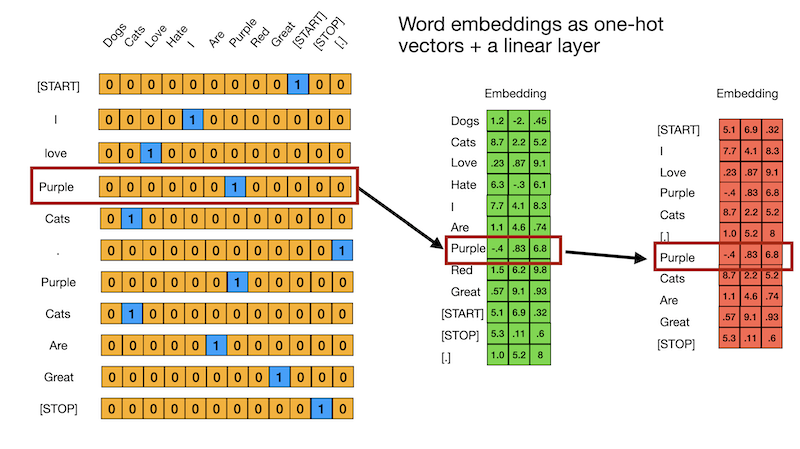


#### **Q2**

Complete the following implementation of a word embedding PyTorch layer. The `forward` method should take as input an $N \times L$ tensor of integers corresponding to a batch of sentences represented by token ids in the range 0 to 1000 and return an $N \times L \times D$ tensor replacing each integer entry with the corresponding row of the embdedding matrix. The `__init__` method should take the *embedding dimension* as input. That is, the length of the vector being used to represent each word.

*Hint: You'll want to use the `nn.Parameter` class for the embedding matrix, just as we did for the weight matricies for our own version of the `Linear` layer. Make sure to initialize the entries of this matrix randomly! For `forward` you should not need any loops. Try using the input matrix to index the embedding matrix*

In [19]:
class Embedding(nn.Module):
  def __init__(self, embedding_dimension):
      super().__init__() # Needed for PyTorch!

      self.embedding_matrix = nn.Parameter((embedding_dimension ** -0.5) * torch.randn((1000, embedding_dimension)))

  def forward(self, x):
      return self.embedding_matrix[x]

# Test output shape
x, y = next(iter(valid_loader))
assert Embedding(64)(x).shape == torch.Size([256, 112, 64])

Our goal is ultimately to create a language model. To do so we'll need a neural network layer that can take as input sequences of different lengths. One such layer that we've seen is a *Recurrent Neural Network Layer*. Let's refresh our memory on what this looks like. We'll let $\mathbf{x}_i$ refer to the vector representing ith word in our input. Our layer will *transform* our featues so that after the layer we'll have a new representation for word $i$: $\mathbf{\phi}_i$. A recurrent layer defines $\phi_i$ recursively as:

$$\phi_i = \text{ReLU}(\phi_{i-1}^T \mathbf{W}_\phi + \mathbf{x}_i^T \mathbf{W}_x + \mathbf{b})$$

Here we'll used the ReLU activation function, but this could just as easily be any other activation. For simplicity, we'll assume that when computing the representation $\phi_{0}$ we can pretend the previous value was 0. That is, we'll assume:
$$\phi_{-1}=\mathbf{0}$$

Notice that at every location we'll use the same parameters and these parameters will define a linear function.


#### **Q3**

Complete the implementation of an RNN layer below, using the definition above.

*Hint: You can assume that `forward` is always given a batch of inputs of size N. The formula above is for a single input. `x[n, i]` will give us the (length $D$) representation for the $i^{th}$ word in sentence $n$, while `x[:, i]` will give us an $N \times D$ matrix of the representation of the $i^{th}$ word in every sentence. Because each word's new representation depends on the previous word's new representation, you'll need to loop over every word position explicitly.*

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        ''' Computes the forward pass of an RNN

        Inputs:
            x: tensor (float), An N x L x D tensor of input data

        Returns:
            h: tensor (float), An N x L x H tensor of transformed features
        '''
        x = self.input_layer(x)
        carry = torch.zeros_like(x[..., 0, :])
        outputs = torch.zeros_like(x)

        for i in range(x.shape[-2]):
            carry = x[..., i, :] + self.hidden_layer(carry)
            carry = self.activation(carry)
            outputs[..., i, :] = carry

        return outputs

As with any neural network layer represented as a PyTorch module, we can compose several RNN layers together to make a more complex network.

In [25]:
class RNNGenerator(nn.Module):
  def __init__(self, vocab_size=1000, dimension=128):
    super().__init__()
    self.embedding = Embedding(dimension)
    self.block1 = RNN(dimension, dimension)
    self.block2 = RNN(dimension, dimension)
    self.block3 = RNN(dimension, dimension)
    self.output = nn.Linear(dimension, vocab_size)

  def forward(self, x):
    x = self.embedding(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    return self.output(x)

model = RNNGenerator()

You can see that the final layer of this network is a linear function that outputs our final prediction. This linear function is applied at each word separately, so the output for a given word $i$ is computed as:

$$f(\mathbf{x})_i=\phi_i^T \mathbf{W}_0 +\mathbf{b}_0$$

We can apply this model to a batch of data and see that it gives use 1000 outputs for each word in each sentece. That is the output size is $N \times L \times 1000$.

In [26]:
print(model(next(iter(train_loader))[0]).shape)

torch.Size([64, 26, 1000])


As we saw, each target $y_i$ is simply the next word in the sentence, so $y_i =x_{i+1}$. This is our *autoregressive language modelling* framework or *next-word prediction*. Since we have 1000 possible tokens (words), we essentially need to make a prediction for each target of one of 1000 classes. We'll use our 1000 dimensional output at each word to estimate the probability of each possible next word. Recall that we can use the **Softmax** function to map an arbitrary vector to a positive vector that sums to 1.
$$p(y_i = c | \mathbf{x}_{0}, \mathbf{x}_{i}) = \text{Softmax}(\phi_i^T \mathbf{W}_0 +\mathbf{b}_0)_c$$
This says that the probability that $y_i$ is some token $c$ is modelled as the $c^{th}$ output of the softmax function.

With this in mind we can now define our **negative log-likelihood loss** for a given word as:
$$\text{NLL}(y_i, \mathbf{x}, \mathbf{W}) = -\log p(y_i | \mathbf{x}_{0}, \mathbf{x}_{i}) = -\log \text{Softmax}(\phi_i^T \mathbf{W}_0 +\mathbf{b}_0)_{y_i}$$

We want to calculate this loss over each of the $L$ words in each of our $N$ sentences, so we should be taking the softmax over the *last* dimension of the input (of size 1000).

#### **Q4**

Complete the method below to compute the negative log-likelihood for a batch of sentences given the output of the network and the labels. Note that the output of the network will be of size $N \times L \times 1000$, as shown above while the targets ($y$), will be a matrix of token ids of size $N \times L$ (again each token id is in the range [0-999]). The output should be an $N \times L$ matrix of `float` representing the negative log-likelihood loss for each predicted word.

*Hint: an appropriate `softmax` function has been provided for you!*


In [27]:
def softmax(x):
    # Compute the softmax for each entry in a tensor
    ex = torch.exp(x)
    sum_ex = torch.sum(ex, dim=-1, keepdims=True)
    return ex / sum_ex

def autoregressive_loss(f, y):
    ''' The loss for each word in a batch of predictions.

        Inputs:
            f: tensor (float), An N x L x 1000 tensor network outputs
            y: tensor (int), An N x L tensor of true token ids in the range [0-999]

        Returns:
            loss: tensor (float), An N x L tensor of losses
        '''
    loss = nn.CrossEntropyLoss(reduction='none')(f.permute(0, 2, 1), y)
    return torch.mean(loss)


For our final loss we'll need a single number, in this case we'll take the average NLL over every word in every sentence. In the simplest case this would look like:
$$ \text{Loss}(\mathbf{y}, \mathbf{X}, \mathbf{W}) = \frac{1}{N\cdot L} \sum_{n=1}^{N}\sum_{i=1}^{L} \text{NLL}(y_{ni}, \mathbf{x}_{ni}, \mathbf{W})$$

However, this isn't quite right! Remember that our actual sentences can be different lengths and that shorter sentences are lengthened with extra `<pad>` tokens to be length $L$. For example if our longest sentence has 8 words, then $L=8$ and we need to transform:

`<start> I love purple cats <stop>` -> `<start> I love purple cats <stop>  <pad> <pad>`

Since `<pad>` tokens don't correspond to actual words in a sentence, we don't want to try to predict them and therefore we'll want to exclude words where $y_i$ is `<pad>`. In our setup `<pad>` is represented by a token id of `0`. So our loss should actually be:


$$ \text{Loss}(\mathbf{y}, \mathbf{X}, \mathbf{W}) = \frac{1}{\sum_{n=1}^{N}\sum_{i=1}^{L} \mathbb{I}(y_{ni} > 0)} \sum_{n=1}^{N}\sum_{i=1}^{L} \mathbb{I}(y_{ni} > 0) \text{NLL}(y_{ni}, \mathbf{x}_{ni}, \mathbf{W})$$

Here $\mathbb{I}(\cdot)$ is the indicator function so:
$$ \mathbb{I}(y_{ni} > 0) = \begin{cases} 1 \text{ if }y_{ni} > 0 \\ 0 \text{ if }y_{ni} = 0\end{cases}$$


#### **Q5**

Modify your `autoregressive_loss` function to take the mean loss over all words where $y_{ni}>0$.

*Hint: `torch.where` may come in handy here*

In [28]:
def autoregressive_loss(f, y):
    ''' The mean loss for each word in a batch of predictions.

        Inputs:
            f: tensor (float), An N x L x 1000 tensor network outputs
            y: tensor (int), An N x L tensor of true token ids in the range [0-999]

        Returns:
            loss: (float) The averge loss
        '''
    loss = nn.CrossEntropyLoss(reduction='none')(f.permute(0, 2, 1), y)
    loss = torch.where(y != 2, loss, 0.)
    return torch.mean(loss)

Ok, we're finally ready to do some training!

#### **Q6**

Complete the train loop below. At each iteration, make sure to compute the model output and the loss using the `autoregressive_loss` function you just wrote. Then do any nessecary steps for gradient descent using the provided optimizer.

  2%|▏         | 101/4101 [00:03<02:31, 26.35it/s]


Text(0.5, 1.0, 'Loss vs. Iterations')

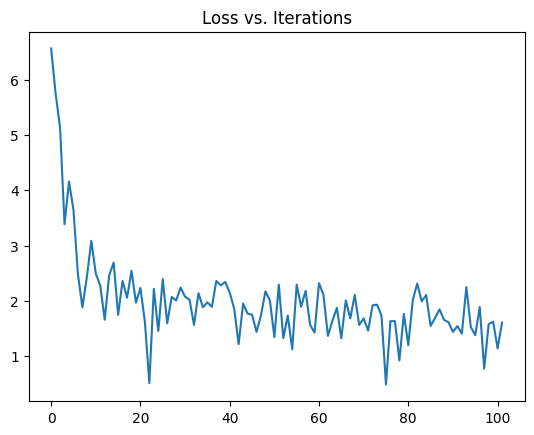

In [29]:
# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Do model creation here so that the model is recreated each time the cell is run
model = model.to(device)
model.train()

# Create the optimizer, just like we have with the built-in optimizer
opt = torch.optim.Adam(model.parameters(), 0.01)

# Information for plots
train_losses = []

for iteration, (train_X, train_Y) in enumerate(tqdm.tqdm(train_loader)):
    # Grab the batch of data and send it to the correct device
    train_X, train_Y = train_X.to(device), train_Y.to(device)

    # Compute the output, loss, and gradient and take a step of gradient descent
    train_output = model(train_X)

    # Compute loss
    loss = autoregressive_loss(train_output, train_Y)

    # Compute gradient
    model.zero_grad()
    loss.backward()

    # Take a step of gradient descent
    with torch.no_grad():
        opt.step()

    train_losses.append(loss.item())

    if iteration > 100:
      break


# Plot the loss over the first 100 iterations
plt.plot(train_losses)
plt.title('Loss vs. Iterations')

#### **Q7**
You might notice that the plotted loss above has pretty poor behaivior! This could be due to vanishing or exploding gradients. Briefly explain, why RNNs might be especially prone to this problem and how you might address it. Then show how you might implement this approach within your RNN layer.

RNNs are especially prone to this problem because information passes through many layers. We could try to fix this with normalization or residual connections.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        ''' Computes the forward pass of an RNN

        Inputs:
            x: tensor (float), An N x L x D tensor of input data

        Returns:
            h: tensor (float), An N x L x H tensor of transformed features
        '''
        x = self.input_layer(x)
        carry = torch.zeros_like(x[..., 0, :])
        outputs = torch.zeros_like(x)

        for i in range(x.shape[-2]):
            carry = x[..., i, :] + self.hidden_layer(carry)
            carry = self.activation(carry)

            # Normalize the carry
            carry = (carry - carry.mean(dim=-1, keepdims=True)) / carry.std(dim=-1, keepdims=True)
            outputs[..., i, :] = carry

        return outputs

# Create a model
model = RNNGenerator()

Try out your implementation by copying your training loop from above (this does not need to actually improve on Q6 for full credit).

  2%|▏         | 101/4101 [00:03<02:20, 28.46it/s]


Text(0.5, 1.0, 'Loss vs. Iterations')

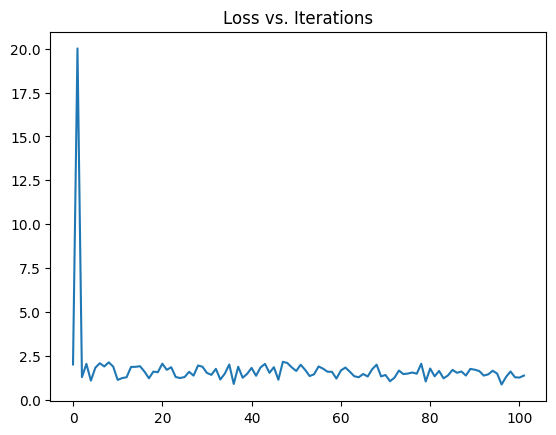

In [30]:
# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Do model creation here so that the model is recreated each time the cell is run
model = model.to(device)
model.train()

# Create the optimizer, just like we have with the built-in optimizer
opt = torch.optim.Adam(model.parameters(), 0.01)

# Information for plots
train_losses = []

for iteration, (train_X, train_Y) in enumerate(tqdm.tqdm(train_loader)):
    # Grab the batch of data and send it to the correct device
    train_X, train_Y = train_X.to(device), train_Y.to(device)

    # Compute the output, loss, and gradient and take a step of gradient descent
    train_output = model(train_X)

    # Compute loss
    loss = autoregressive_loss(train_output, train_Y)

    # Compute gradient
    model.zero_grad()
    loss.backward()

    # Take a step of gradient descent
    with torch.no_grad():
        opt.step()

    train_losses.append(loss.item())

    if iteration > 100:
      break


# Plot the loss over the first 100 iterations
plt.plot(train_losses)
plt.title('Loss vs. Iterations')

If we want to make use of our language model, we'll need a way to actually generate text from it. Recall from class that we'll need to do this one token at a time. We know that any text will always start with our designated `<start>` token, which has token id `1` in our vocabulary. Therefore we can start generating a sentence by using our model to *sample* the next word given `<start>`.

To sample a word we'll use our model to predict a probability distribution over every possible next token and sample from that distribution. For example we might have the following sequence of samples:

$$\text{I} \sim p(y_1| \text{<start>})$$
$$\text{love} \sim p(y_2| \text{<start>}, \text{I})$$
$$\text{purple} \sim p(y_3| \text{<start>}, \text{I}, \text{love})$$
$$\text{cats} \sim p(y_4| \text{<start>}, \text{I}, \text{love})$$
$$\text{<stop>} \sim p(y_4| \text{<start>}, \text{I}, \text{love}, \text{purple})$$

The following function will take a tensor of size $N \times ... \times C$, where all entries are non-negative and the entries along the last dimension sum to 1 (therefore forming a valid categorical distribution). It returns a sample tensor of ints of size $N\times ...$, sampling each entry from the corresponding input distribution.

In [33]:
import torch
def sample_categorical(probs):
  assert torch.all(torch.isclose(p.sum(dim=-1), torch.tensor(1.)))
  return torch.distributions.Categorical(probs=probs).sample()

# 4 x 3 matrix of probabilities (each row sums to 1.)
p = torch.tensor([[0.3, 0.2, 0.5],
                  [0.0, 0.9, 0.1],
                  [0.9, 0.0, 0.1],
                  [0.3, 0.3, 0.4]])

# Length 4 vector of samples
print(sample_categorical(p))

# 2 x 2 x 3 matrix of probabilities (each final dimension sums to 1.)
p = torch.tensor([
                  [
                    [0.3, 0.2, 0.5],
                    [0.0, 0.9, 0.1]],
                  [
                    [0.9, 0.0, 0.1],
                    [0.3, 0.3, 0.4]
                  ]
                  ])

# 2x2 matrix of samples
print(sample_categorical(p))

tensor([2, 1, 0, 0])
tensor([[2, 1],
        [0, 0]])


#### **Q8**

Complete the function below to sample a *batch* of sentences given a trained model. The function should return a matrix of size $N \times L$, where $N$ is the given batch size and $L$ is the given maximum sentence length.

*Hint: Remember that you'll need to sample sequentially, one word at a time in each sentence, so you should have a loop that runs $L$ times. Also remember that the model outputs a prediction for every word in a sentence, but at each step you only need the prediction for the last word that has yet to be seen.*

In [34]:
def sample(model, data, batch_size=1, max_length=50):
  model.eval()

  # Start with an N x 1 matrix where each entry is just the <start> token.
  # After the first iteration this should be N x 2, then N x 3 ... until N x L.
  sample = torch.ones((batch_size, 1)).int().to(device)
  for i in range(max_length):
    new_sample = sample_categorical(softmax(model(sample)))[..., -1:]
    sample = torch.cat([sample, new_sample], dim=-1)
  return sample

# Test sampling
sample_sentence = sample(model, data)
print('Tokens:', sample_sentence)
print('Text:', convertToText(sample_sentence, data.eng_vocab))

Tokens: tensor([[  1,   6, 101,  61,  15, 150, 496,  11,   4,  41,   7,  29, 133,  60,
         358,   4, 191,  26,   4,  14, 336,  52,  36, 274,   4,   4,  96,  82,
         117,  18,   7,   4,  14, 243,  63,  15, 279,   4, 264, 232, 318,  21,
           4,  61,  10,  91,   4,  12, 411,   0,   0]])
Text: [' I will can the carity to. stproenant.ive me. 0loight..le here usmt. ap with the dog.ine couldanded. can youce.? anymore<pad><pad>']


Now recall that RNNs actually aren't ideal for language modeling. In recent years they've mostly been replaced by *attention* layers. A *scaled dot-product attention* layer is defined by the formula:
$$\text{Attention}(Q, K, V) = \text{Softmax}\bigg(\frac{QK^T}{\sqrt{h}} \bigg)V$$

In the above formula, $Q$, $K$ and $V$ are all assumed to be $L \times h$ matrices given by affine functions of the input:
$$Q = X W_Q + b_Q$$
$$K = X W_K + b_K$$
$$V = X W_V + b_V$$

#### **Q9**

Complete the following implementation of a (single-headed) attention layer. The `forward` method should assume a *batched* input of shape $N \times L \times d$, so the attention equation above should be applied for each observation yielding an $N \times L \times h$ output.

*Hint: you can use `t.transpose(-1, -2)` to transpose the last two dimensions of a tensor, e.g. to turn an $N \times L \times h$ tensor into an $N \times h \times L$ tensor*

In [35]:
class Attention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.key_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.d = hidden_size

    def forward(self, x):
        '''
        Inputs:
          x: tensor (float), an N x L x d tensor of embeddings

        Outputs:
          transformed: tensor (float), and N x L x h tensor of transformed
                        embeddings, where h is the specified hidden_size
        '''
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)

        W = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d)
        W = torch.nn.functional.softmax(W, dim=-1)
        return torch.matmul(W, V)

In order to do autoregressive generation, we need to make sure that future words don't influence past words. As we saw in class we can accomplish this by *masking* our attention matrix before applying the `softmax` function:

$$\text{MaskedAttention}(Q, K, V) = \text{Softmax}\bigg( \text{Mask} \bigg( \frac{QK^T}{\sqrt{h}} \bigg) \bigg)V$$

Our masking function will work as follows:
$$\text{Mask}(M)_{ij} = \begin{cases} -\infty \text{ if } i < j \\ M_{ij} \text{ if } i \geq j\end{cases}$$
After the `softmax` operation entries set to $-\infty$ will become $0$. Luckily PyTorch provides us with a useful function called `torch.tril` that can help us:
$$\text{TriL}(M)_{ij} = \begin{cases} 0\  \ \ \  \text{ if } i < j \\ M_{ij} \text{ if } i \geq j\end{cases}$$

#### **Q10**

Complete the following implementation of *masked attention*. Using your previous attention implementation as a starting point.

In [36]:
class MaskedAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.key_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.d = hidden_size

    def forward(self, x):
        '''
        Inputs:
          x: tensor (float), an N x L x d tensor of embeddings

        Outputs:
          transformed: tensor (float), and N x L x h tensor of transformed
                        embeddings, where h is the specified hidden_size
        '''
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)

        W = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d)
        mask = torch.tril(torch.ones_like(W))
        W = torch.where(mask == 0, -torch.inf, W)

        W = torch.nn.functional.softmax(W, dim=-1)
        return torch.matmul(W, V)

Finally the last addition we'll make to our attention layer (for now) is to implement a *Multi-headed attention layer*. In this case our layer will take an additional argument `num_heads` that specifies the number of attention heads to use.

Recall that for multi-headed attention we'll compute $Q$, $K$ and $V$ the same way as before, but this time before computing the attention forumla as above, we'll split each into `num_heads` chunks along the last dimension. That is, if $Q$ is of shape $N \times L \times h$, and `num_heads` is 8, we'll create 8 new query matricies $Q_1...Q_8$, each of size $N \times L \times \frac{h}{8}$.

We'll then compute `num_heads` different attention outputs, where the output for head `i` is:
$$\text{Head}_i = \text{Softmax}\bigg( \text{Mask} \bigg( \frac{Q_iK_i^T}{\sqrt{h/8}} \bigg) \bigg)V_i$$
Each head will similarly return an output of size $N \times L \times \frac{h}{8}$, and we can then use `torch.cat(heads, dim=-1)` to recombine them into a final output tensor of size $N \times L \times h$.

#### **Q11**

Complete the implementation of `MaskedMultiheadedAttention` below, using the formula above.

In [37]:
class MaskedMultiheadAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads=1):
        super().__init__()
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.key_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.d = hidden_size // num_heads
        self.num_heads = num_heads

    def forward(self, x):
      '''
        Inputs:
          x: tensor (float), an N x L x d tensor of embeddings

        Outputs:
          transformed: tensor (float), and N x L x h tensor of transformed
                        embeddings, where h is the specified hidden_size
        '''
      Q = self.query_layer(x)
      K = self.key_layer(x)
      V = self.value_layer(x)

      Q = Q.reshape(Q.shape[:-1] + (self.num_heads, self.d)).transpose(-2, -3)
      K = K.reshape(K.shape[:-1] + (self.num_heads, self.d)).transpose(-2, -3)
      V = V.reshape(V.shape[:-1] + (self.num_heads, self.d)).transpose(-2, -3)

      W = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.d)
      mask = torch.tril(torch.ones_like(W))
      W = torch.where(mask == 0, -torch.inf, W)

      W = torch.nn.functional.softmax(W, dim=-1)
      phi = torch.matmul(W, V).transpose(-2, -3)
      return phi.reshape(phi.shape[:-2] + (-1,))

#### **Q12**

Explain, in your own words, the potential advantages of attention-based models over RNN-based models for the language modelling problem.

Attention layers can handle aribitray-length dependencies and don't suffer from vanishing/exploding gradients.

# Part 2: Trying it out! (Optional)

There are no more questions in this homework, but if you'd like to try out training an actual language model using the code you wrote, feel free to experiment with the implementation below!

In [38]:
epsilon = 1e-7
class LayerNorm(nn.Module):
    '''
        The same LayerNorm implementation we saw before.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        xmean = x.mean(dim=(-1, -2), keepdims=True)
        xvar = x.var(dim=(-1, -2), keepdims=True)
        return (x - xmean) / torch.sqrt(xvar + epsilon)


class PositionalEncoding(nn.Module):
    '''
        A layer to add positional encodings to the input.
    '''
    def forward(self, x):
        pos = torch.arange(x.shape[-2]).unsqueeze(1)
        i = torch.arange(x.shape[-1] // 2).unsqueeze(0)
        embedding = torch.zeros_like(x)
        embedding[..., ::2] = torch.sin(pos / 10000. ** (2 * i / x.shape[-1]))
        embedding[..., 1::2] = torch.cos(pos / 10000. ** (2 * i / x.shape[-1]))
        return x + embedding

class TransformerBlock(nn.Module):
    '''
        A block of a transformer decoder.
    '''
    def __init__(self, input_size, hidden_size, num_heads=8):
        super().__init__()
        self.attention = MaskedMultiheadAttention(input_size, hidden_size, num_heads)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.ReLU()
        self.ln1 = LayerNorm()
        self.ln2 = LayerNorm()

    def forward(self, x):
        x = self.ln1(self.attention(x) + x)
        x = self.ln2(self.linear2(self.activation(self.linear1(x))) + x)
        return x

class TransformerGenerator(nn.Module):
  '''
      A full transformer decoder model.
  '''
  def __init__(self, vocab_size=1000, dimension=128, num_heads=8):
    super().__init__()
    self.embedding = Embedding(dimension)
    self.positional_encoding = PositionalEncoding()
    self.block1 = TransformerBlock(dimension, dimension, num_heads=num_heads)
    self.block2 = TransformerBlock(dimension, dimension, num_heads=num_heads)
    self.block3 = TransformerBlock(dimension, dimension, num_heads=num_heads)
    self.output = nn.Linear(dimension, vocab_size)

  def forward(self, x):
    x = self.embedding(x)
    x = self.positional_encoding(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    return self.output(x)



In [39]:
import torch
import torch.nn as nn
from torchsummary import summary
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt

# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.001

from torch.optim import Adam

def gradient_descent(model, train_loader, valid_loader, optimizer=Adam, learning_rate=0.001, criterion=nn.CrossEntropyLoss(), num_epochs=10, batch_size=256):

    # Do model creation here so that the model is recreated each time the cell is run
    model = model.to(device)
    model.train()

    t = 0
    # Create the optimizer, just like we have with the built-in optimizer
    opt = optimizer(model.parameters(), learning_rate)

    # A master bar for fancy output progress
    mb = master_bar(range(num_epochs))

    # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    for epoch in mb:

        #
        # Training
        #
        model.train()

        train_N = len(train_loader.dataset)
        num_train_batches = len(train_loader)
        train_dataiterator = iter(train_loader)

        train_loss_mean = 0

        for batch in progress_bar(range(num_train_batches), parent=mb):

            # Grab the batch of data and send it to the correct device
            train_X, train_Y = next(train_dataiterator)
            train_X, train_Y = train_X.to(device), train_Y.to(device)


            # Compute the output
            train_output = model(train_X)

            # Compute loss
            train_loss = criterion(train_output, train_Y)

            num_in_batch = len(train_Y)
            tloss = train_loss.item() * num_in_batch / train_N
            train_loss_mean += tloss
            train_losses.append(train_loss.item())

            # Compute gradient
            model.zero_grad()
            train_loss.backward()

            # Take a step of gradient descent
            t += 1
            with torch.no_grad():
                opt.step()

        #
        # Validation
        #
        model.eval()

        valid_N = len(valid_loader.dataset)
        num_valid_batches = len(valid_loader)

        valid_loss_mean = 0
        valid_correct = 0
        valid_total = 0

        with torch.no_grad():

            # valid_loader is probably just one large batch, so not using progress bar
            for valid_X, valid_Y in valid_loader:

                valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

                valid_output = model(valid_X)

                valid_loss = criterion(valid_output, valid_Y)

                num_in_batch = len(valid_Y)
                vloss = valid_loss.item() * num_in_batch / valid_N
                valid_loss_mean += vloss
                valid_losses.append(valid_loss.item())

                # Convert network output into predictions (one-hot -> number)
                predictions = valid_output.argmax(-1)

                # Sum up total number that were correct
                valid_correct += (predictions == valid_Y).type(torch.float).sum().item()
                valid_total += torch.ones_like(predictions).type(torch.float).sum().item()

        valid_accuracy = 100 * (valid_correct / valid_total)

        # Report information
        tloss = f"Train Loss = {train_loss_mean:.4f}"
        vloss = f"Valid Loss = {valid_loss_mean:.4f}"
        vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
        mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

        # Update plot data
        max_loss = max(max(train_losses), max(valid_losses))
        min_loss = min(min(train_losses), min(valid_losses))

        x_margin = 0.2
        x_bounds = [0 - x_margin, num_epochs + x_margin]

        y_margin = 0.1
        y_bounds = [min_loss - y_margin, max_loss + y_margin]

        valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
        valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
        graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

        mb.update_graph(graph_data, x_bounds, y_bounds)

    print(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

Using 'cpu' device.


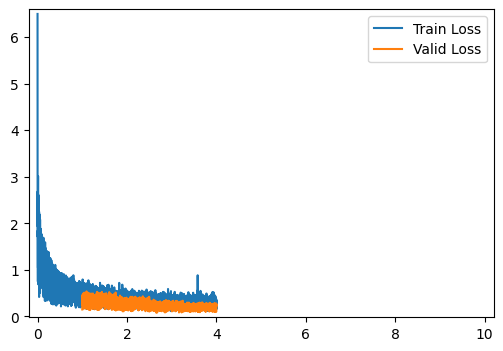

KeyboardInterrupt: 

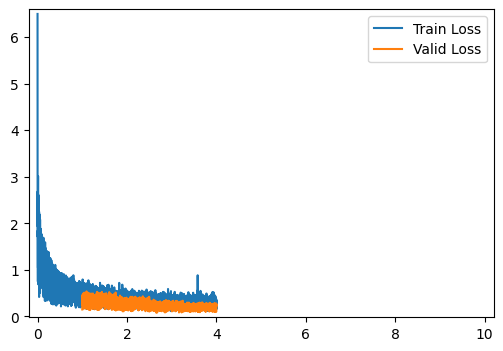

In [41]:
# Test out the model!
model = TransformerGenerator()
gradient_descent(model, train_loader, valid_loader, criterion=autoregressive_loss)

In [46]:
# Test sampling
sample_sentence = sample(model, data)
print('Tokens:', sample_sentence)
print('Text:', convertToText(sample_sentence, data.eng_vocab))

Tokens: tensor([[  1,  44, 774,  95, 830,  27, 571,   9,  51, 821,  11,   9,  11,  59,
           4, 218,   4,  46,   4,  61,   4, 247,   4, 837,   4,  23,   4, 936,
           4,   0,  28,  72, 588, 797,   4, 579, 358, 633, 418, 164, 164,  84,
         650, 299,   4,   0,   4,   0,  11,  15,  51]])
Text: [' He kept chose that places are crazy tos to Mary. Please. did. can. Let.Y. You. vacation.<pad> was go part.".Nant language into out out his under sp.<pad>.<pad> to the are']
